In [2]:
#Repite el ejemplo Arxiv ML Papers (I), agrega dos nuevas columnas al DataFrame final: 
#Abstract, con el resumen de cada paper; Submitted, con la fecha en la que fue agregado al sistema. 
#Hint: Ambos elementos se encuentran dentro de la url encontrada.
from requests_html import HTMLSession
import pandas as pd
url = "https://arxiv.org/list/stat.ML/recent"
with HTMLSession() as sess:
    r = sess.get(url)
r


<Response [200]>

In [3]:
divpage = r.html.find("div[id='dlpage']", first=True)

In [7]:
papers_links = divpage.find("dt")
len(papers_links)

25

In [5]:
papers_titles = divpage.find("dd")
len(papers_titles)

25

In [9]:
values = []
for link_secc, title_secc in zip(papers_links, papers_titles):
    title = title_secc.find("div[class='list-title mathjax']", first=True).text
    
    abstract_url = link_secc.find("a[title='Abstract']", first=True).absolute_links
    abstract_url, *_ = abstract_url
    
    values.append([title, abstract_url])

df_values = pd.DataFrame(values, columns=["title", "url"])
df_values.head()


,title,url
0,Title: PAPRIKA: Private Online False Discovery...,https://arxiv.org/abs/2002.12321
1,Title: MetFlow: A New Efficient Method for Bri...,https://arxiv.org/abs/2002.12253
2,Title: Semi-supervised Anomaly Detection on At...,https://arxiv.org/abs/2002.12011
3,Title: Fast and Three-rious: Speeding Up Weak ...,https://arxiv.org/abs/2002.11955
4,Title: Max-Affine Spline Insights into Deep Ge...,https://arxiv.org/abs/2002.11912


<Response [200]>

AttributeError: 'Response' object has no attribute 'html'

In [23]:
abstract = r.html.find("blockquote[class='abstract mathjax']", first=True).text
#print(abstract)

In [37]:
len(df_values["url"])
df_values["url"][0]

'https://arxiv.org/abs/2002.12321'

In [51]:
values = []

for i in range(len(df_values["url"])):
    with HTMLSession() as sess:
        r = sess.get(df_values["url"][i])
    
    date = r.html.find("div[class='dateline']", first=True).text    
    abstract = r.html.find("blockquote[class='abstract mathjax']", first=True).text 
    values.append([date, abstract])

df_values2 = pd.DataFrame(values, columns=["date", "abstract"])




In [52]:
df_values["date"] = df_values2["date"]
df_values["abstract"] = df_values2["abstract"]
df_values.head()

,title,url,date,abstract
0,Title: PAPRIKA: Private Online False Discovery...,https://arxiv.org/abs/2002.12321,(Submitted on 27 Feb 2020),"Abstract: In hypothesis testing, a false disco..."
1,Title: MetFlow: A New Efficient Method for Bri...,https://arxiv.org/abs/2002.12253,(Submitted on 27 Feb 2020),"Abstract: In this contribution, we propose a n..."
2,Title: Semi-supervised Anomaly Detection on At...,https://arxiv.org/abs/2002.12011,(Submitted on 27 Feb 2020),Abstract: We propose a simple yet effective me...
3,Title: Fast and Three-rious: Speeding Up Weak ...,https://arxiv.org/abs/2002.11955,(Submitted on 27 Feb 2020),Abstract: Weak supervision is a popular method...
4,Title: Max-Affine Spline Insights into Deep Ge...,https://arxiv.org/abs/2002.11912,(Submitted on 26 Feb 2020),Abstract: We connect a large class of Generati...


In [92]:
#Por medio de la librería requests y el API de AlphaVantage, 
#consigue los precios históricos de las monedas ["MXN", "EUR", "BRL", "ARS", "CHF"] 
#respecto al dólar (todos los precios deben estar en dólares). 
#Crea un DataFrame con cada colúmna la moneda de referencia:
import requests
import os
from collections import defaultdict
%config InlineBackend.figure_format = "retina"

In [93]:
url = "https://www.alphavantage.co"
base_url = "https://www.alphavantage.co/query"
# Cargamos el API Key de Alpha Vantage (es personal)
avkey = "3O7HVKXH1TMDFHQC" #os.environ["ALPHA_VANTAGE_KEY"]

In [118]:
monedas = ["MXN", "EUR", "BRL", "ARS", "CHF"]
tabla = defaultdict(dict)

In [119]:
for i in monedas:
    intraday1 = {
        "function": "FX_DAILY",
        "to_symbol": "USD",
        "from_symbol": i,
        "apikey": avkey,
        "outputsize": "full",
    }

    r = requests.get(base_url, params=intraday1)
    data= r.json()
    df_data = pd.DataFrame(data["Time Series FX (Daily)"], dtype=float).T.sort_index()
    tabla[i] = df_data["4. close"]

In [125]:
tabla_fin = pd.DataFrame(tabla, dtype=float).dropna().sort_index()
tabla_fin = tabla_fin[tabla_fin.index>= "2014-11-24"]
tabla_fin 

,MXN,EUR,BRL,ARS,CHF
2014-11-24,0.0732,1.2438,0.3920,0.1169,1.0342
2014-11-25,0.0731,1.2473,0.3955,0.1169,1.0370
2014-11-26,0.0728,1.2507,0.3995,0.1168,1.0401
2014-11-27,0.0726,1.2458,0.3947,0.1169,1.0363
2014-11-28,0.0717,1.2451,0.3891,0.1168,1.0351
...,...,...,...,...,...
2020-02-26,0.0518,1.0882,0.2242,0.0157,1.0233
2020-02-27,0.0512,1.1002,0.2224,0.0156,1.0323
2020-02-28,0.0510,1.1029,0.2230,0.0156,1.0353
2020-03-01,0.0503,1.1045,0.2230,0.0156,1.0369


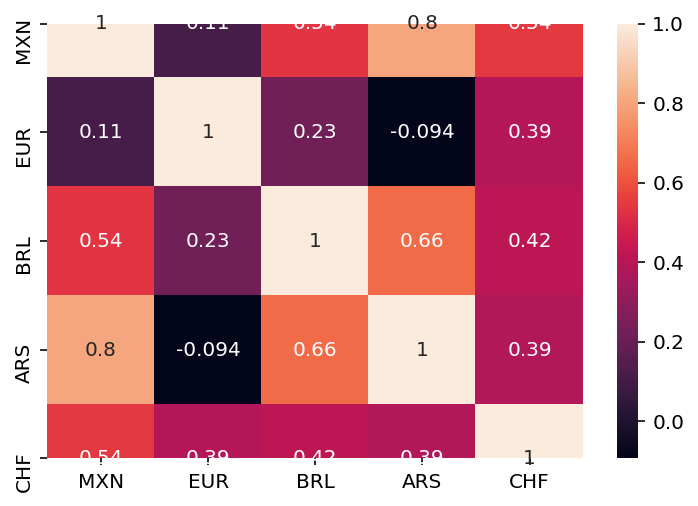

In [130]:
#Con el DataFrame creado en el ejercicio 2, crea el siguiente mapa de calor con la correlación entre 
#cada una de las monedas. hint: Revisa que métodos tiene un DataFrame para crear correlaciones; 
#considera la librería seaborn.
import seaborn as sns
sns.heatmap(tabla_fin.corr(), annot=True)

In [150]:
#Con el DataFrame creado en el ejercicio 2, crea un nuevo DataFrame que incluya una correlación móvil 
#con ventana de 30 días de cada una de las monedas respecto a "MXN". hint: Investiga sobre el método .xs de un DataFrame

corr30 = tabla_fin.rolling(30).corr().dropna()
corr30 = corr30.xs("MXN", level = 1)[["EUR","BRL","ARS","CHF"]]
corr30= corr30[corr30.index>= "2015-03-19"]
corr30

,EUR,BRL,ARS,CHF
2015-03-19,0.900941,0.870440,0.835029,0.916637
2015-03-20,0.874866,0.815453,0.762308,0.903594
2015-03-22,0.866783,0.789977,0.726098,0.900547
2015-03-23,0.835823,0.728781,0.643129,0.885424
2015-03-24,0.801267,0.671188,0.560149,0.877682
...,...,...,...,...
2020-02-26,-0.132666,0.332192,0.146621,-0.273137
2020-02-27,-0.196531,0.504148,0.304529,-0.355744
2020-02-28,-0.268271,0.627480,0.426425,-0.451384
2020-03-01,-0.340049,0.718202,0.533992,-0.538785


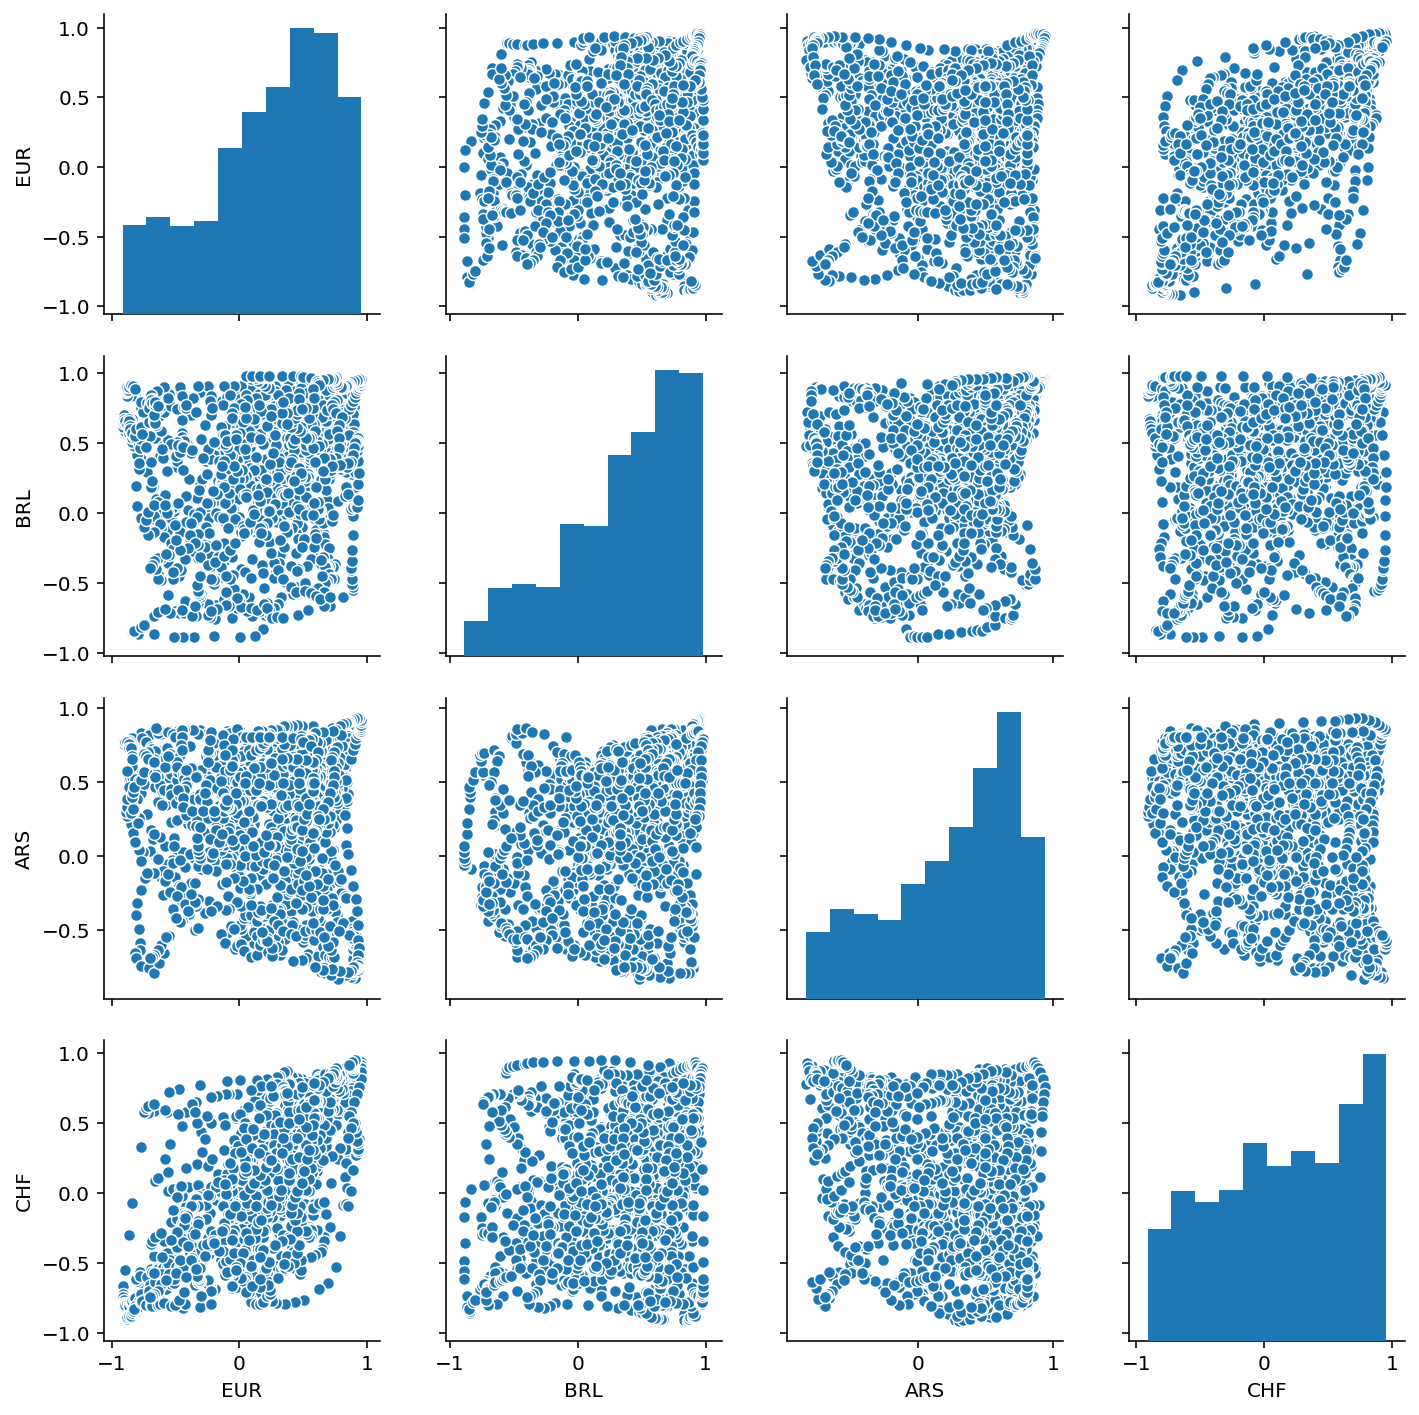

In [152]:
#Con el DataFrame creado en el ejercicio 4, crea la siguiente figura con scatterplots 
#entre todas las combinaciones de las correlaciones respecto a "MXN". ¿Encuentras algún patrón en alguna combinación?
sns.pairplot(corr30, vars = ["EUR","BRL","ARS","CHF"])

#para algunas combinaciones de monedas existe una correlación lineal positiva, sin embargo para otras no es
#isible que exista alguna correlación lineal, sin embargo esta podría ser distinta a lineal.

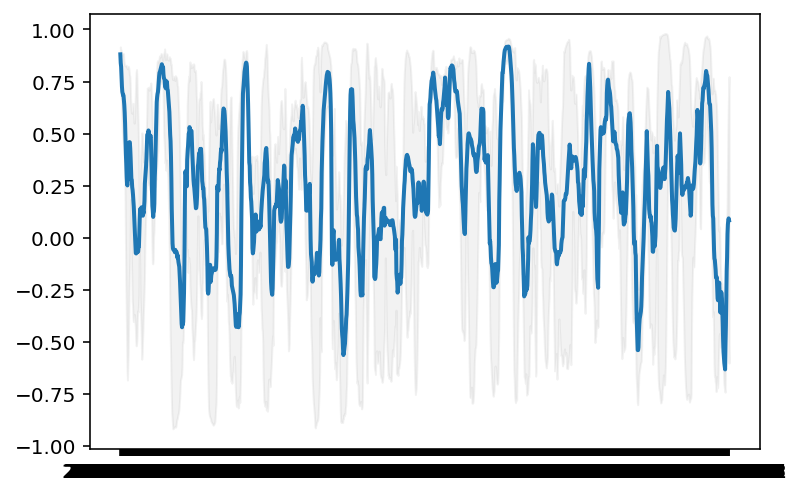

In [161]:
#Con el DataFrame creado en el ejercicio 4, crea la siguiente figura, la cuál representa, a cada observación,
#la correlación promedio entre todas las monedas respecto a "MXN" y unas bandas que representan la correlación máxima 
#y mínima a cada observación.

import matplotlib.pyplot as plt
promedio = corr30.mean(axis=1,skipna=True)
inferior = corr30.min(axis=1,skipna=True)
superior = corr30.max(axis=1,skipna=True)

#Plotting:
plt.plot(promedio, linewidth=2) 
plt.fill_between(corr30.index, inferior, superior, color='grey', alpha=.1) #std curves.


In [163]:
print (os.getcwd())

C:\Users\José Miguel
